In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [14]:
train_df = pd.read_csv("../data/processed/train_df.csv", index_col=0)
test_df = pd.read_csv("../data/processed/test_df.csv", index_col=0)
train_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
2457,8.1,0.33,0.36,7.4,0.037,36.0,156.0,0.99592,3.19,0.54,10.6,6,white
524,5.6,0.35,0.37,1.0,0.038,6.0,72.0,0.99020,3.37,0.34,11.4,5,white
4551,7.0,0.23,0.32,1.8,0.048,25.0,113.0,0.99150,3.11,0.47,11.1,6,white
1056,8.9,0.48,0.53,4.0,0.101,3.0,10.0,0.99586,3.21,0.59,12.1,7,red
3759,7.8,0.19,0.32,7.4,0.015,47.0,124.0,0.99278,2.99,0.39,11.0,6,white


In [15]:
train_df.loc[train_df['quality'] == 3, 'quality'] = 4
# train_df.loc[train_df['quality'] == 4, 'quality'] = '<=4'
# train_df.loc[train_df['quality'] == 8, 'quality'] = '>=8'
train_df.loc[train_df['quality'] == 9, 'quality'] = 8
# train_df['quality'] = train_df['quality'].map(str)
# train_df['quality'] = pd.Categorical(train_df['quality'], categories=['<=4', '5', '6', '7', '>=8'], ordered=True)

test_df.loc[test_df['quality'] == 3, 'quality'] = 4
# test_df.loc[test_df['quality'] == 4, 'quality'] = '<=4'
# test_df.loc[test_df['quality'] == 8, 'quality'] = '>=8'
test_df.loc[test_df['quality'] == 9, 'quality'] = 8
# test_df['quality'] = test_df['quality'].map(str)
# test_df['quality'] = pd.Categorical(test_df['quality'], categories=['<=4', '5', '6', '7', '>=8'], ordered=True)

In [16]:
X_train = train_df.drop(columns=['quality'])
y_train = train_df['quality']
X_test = test_df.drop(columns=['quality'])
y_test = test_df['quality']

In [17]:
# helper function, adapted from 573 lecture 4
# https://pages.github.ubc.ca/mds-2021-22/DSCI_573_feat-model-select_students/lectures/04_feat-importances-selection.html
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [18]:
numeric_features = list(X_train.select_dtypes(include='number').columns)
categorical_features = ['type']

In [19]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_features)
)

In [20]:
# models
dummy = make_pipeline(preprocessor, DummyClassifier(strategy='stratified', random_state=123))
svc = make_pipeline(preprocessor, SVC(kernel='linear', probability=True, random_state=123))
lr = make_pipeline(preprocessor, LogisticRegression(max_iter=5000, random_state=123))
rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))

models = {}
models['Dummy'] = dummy
models['SVC'] = svc
models['Logistic Regression'] = lr
models['Random Forest'] = rf

# scoring metrics
scoring = ["accuracy", "f1_macro", "roc_auc_ovr", "roc_auc_ovo"]

In [21]:
results = {}
for key, value in models.items():
    results[key] = mean_std_cross_val_scores(value, X_train, y_train, return_train_score=True, scoring=scoring, error_score='raise')
cross_val_results = pd.DataFrame(results).rename(
    index={"test_score": "cross_validation_score"}
).T
cross_val_results
# cross_val_results.to_csv('../results/cross_val_results.csv')

,fit_time,score_time,test_accuracy,train_accuracy,test_f1_macro,train_f1_macro,test_roc_auc_ovr,train_roc_auc_ovr,test_roc_auc_ovo,train_roc_auc_ovo
Dummy,0.007 (+/- 0.001),0.021 (+/- 0.002),0.333 (+/- 0.013),0.333 (+/- 0.004),0.193 (+/- 0.011),0.200 (+/- 0.005),0.496 (+/- 0.007),0.501 (+/- 0.003),0.496 (+/- 0.007),0.500 (+/- 0.003)
SVC,3.062 (+/- 0.056),0.187 (+/- 0.008),0.536 (+/- 0.013),0.540 (+/- 0.002),0.243 (+/- 0.006),0.245 (+/- 0.001),0.739 (+/- 0.017),0.751 (+/- 0.005),0.722 (+/- 0.017),0.733 (+/- 0.006)
Logistic Regression,0.225 (+/- 0.035),0.023 (+/- 0.004),0.546 (+/- 0.014),0.551 (+/- 0.006),0.323 (+/- 0.014),0.328 (+/- 0.008),0.758 (+/- 0.016),0.771 (+/- 0.004),0.753 (+/- 0.014),0.766 (+/- 0.003)
Random Forest,0.580 (+/- 0.026),0.068 (+/- 0.001),0.647 (+/- 0.010),1.000 (+/- 0.000),0.502 (+/- 0.025),1.000 (+/- 0.000),0.855 (+/- 0.004),1.000 (+/- 0.000),0.850 (+/- 0.004),1.000 (+/- 0.000)


In [22]:
param_grid_rf = {
    "randomforestclassifier__n_estimators": np.logspace(1, 4, 10, dtype=int),
    "randomforestclassifier__max_depth": np.linspace(1, 30, 10, dtype=int),
}

search_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_grid_rf,
    return_train_score=True,
    n_jobs=-1,
    n_iter=30,
    cv=5,
    random_state=123,
    scoring='roc_auc_ovr',
    error_score='raise'
)

In [23]:
search_rf.fit(X_train, y_train);

In [12]:
# raw_cat = pd.Categorical(train_df['quality'], categories=['<=4', '5', '6', '7', '>=8'], ordered=True)
# raw_cat

['6', '5', '6', '7', '6', ..., '7', '5', '7', '5', '6']
Length: 4547
Categories (5, object): ['<=4' < '5' < '6' < '7' < '>=8']

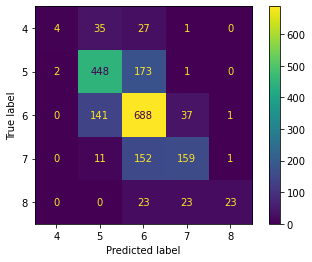

In [24]:
test_cm = ConfusionMatrixDisplay.from_estimator(
    search_rf.best_estimator_, X_test, y_test)
# plt.savefig('../results/f_test_cm.png')

In [26]:
rf_results = {'Random Forest Best n_estimators': search_rf.best_params_['randomforestclassifier__n_estimators'], 
         'Random Forest Best max_depth': search_rf.best_params_['randomforestclassifier__max_depth'],
         'Random Forest Best Score': search_rf.best_score_,
         'Random Forest Roc_Auc Test Score': search_rf.best_estimator_.score(X_test, y_test)}
rf_results = pd.DataFrame(rf_results, index=[0])
rf_results
# rf_results.to_csv('../results/random_forest_results.csv')

,Random Forest Best n_estimators,Random Forest Best max_depth,Random Forest Best Score,Random Forest Roc_Auc Test Score
0,4641,26,0.862807,0.677949


In [29]:
categorical_columns = list(search_rf.best_estimator_.named_steps['columntransformer'].named_transformers_['onehotencoder'].get_feature_names_out())
all_columns = numeric_features + categorical_columns

feature_importances = pd.DataFrame(search_rf.best_estimator_.named_steps['randomforestclassifier'].feature_importances_, 
                                   index=all_columns, columns=['Feature Importances']).sort_values(by='Feature Importances', ascending=False)
feature_importances
feature_importances.to_csv('feature_importances.csv')
